# RNN Model

## 1. Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 2. Đọc Dataset và chia data thành 2 bộ train và test

In [2]:
# Đọc dữ liệu từ file CSV, lấy các cột cần thiết và phân tích cột 'Date' làm chỉ mục
df = pd.read_csv('../Data/gld_price_data.csv', index_col='Date', parse_dates=True, usecols=['Date','GLD', 'USO', 'SLV','EUR/USD'])
# df.sort_values(by='Date', ascending=True, inplace=True)
# df.reset_index(inplace=True)

# Loại bỏ các dòng có giá trị thiếu (NaN) trong dữ liệu
df = df.dropna()

# Tách dữ liệu thành train_data và test_data theo tỉ lệ 80:20
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# In kích thước của tập dữ liệu huấn luyện
print('Shape of data train', train_data.shape)

# In kích thước của tập dữ liệu kiểm tra
print('Shape of data test', test_data.shape)

# Tách biến mục tiêu 'GLD' từ tập dữ liệu huấn luyện
y_train = train_data['GLD']
y_test = test_data['GLD']

# Tách các biến đầu vào (features) từ tập dữ liệu huấn luyện, loại bỏ cột 'GLD'
X_train = train_data.drop(columns=['GLD'])
X_test = test_data.drop(columns=['GLD'])

Shape of data train (1832, 4)
Shape of data test (458, 4)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2290 entries, 2008-01-02 to 2018-05-16
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GLD      2290 non-null   float64
 1   USO      2290 non-null   float64
 2   SLV      2290 non-null   float64
 3   EUR/USD  2290 non-null   float64
dtypes: float64(4)
memory usage: 89.5 KB


### 3. Dataset overview

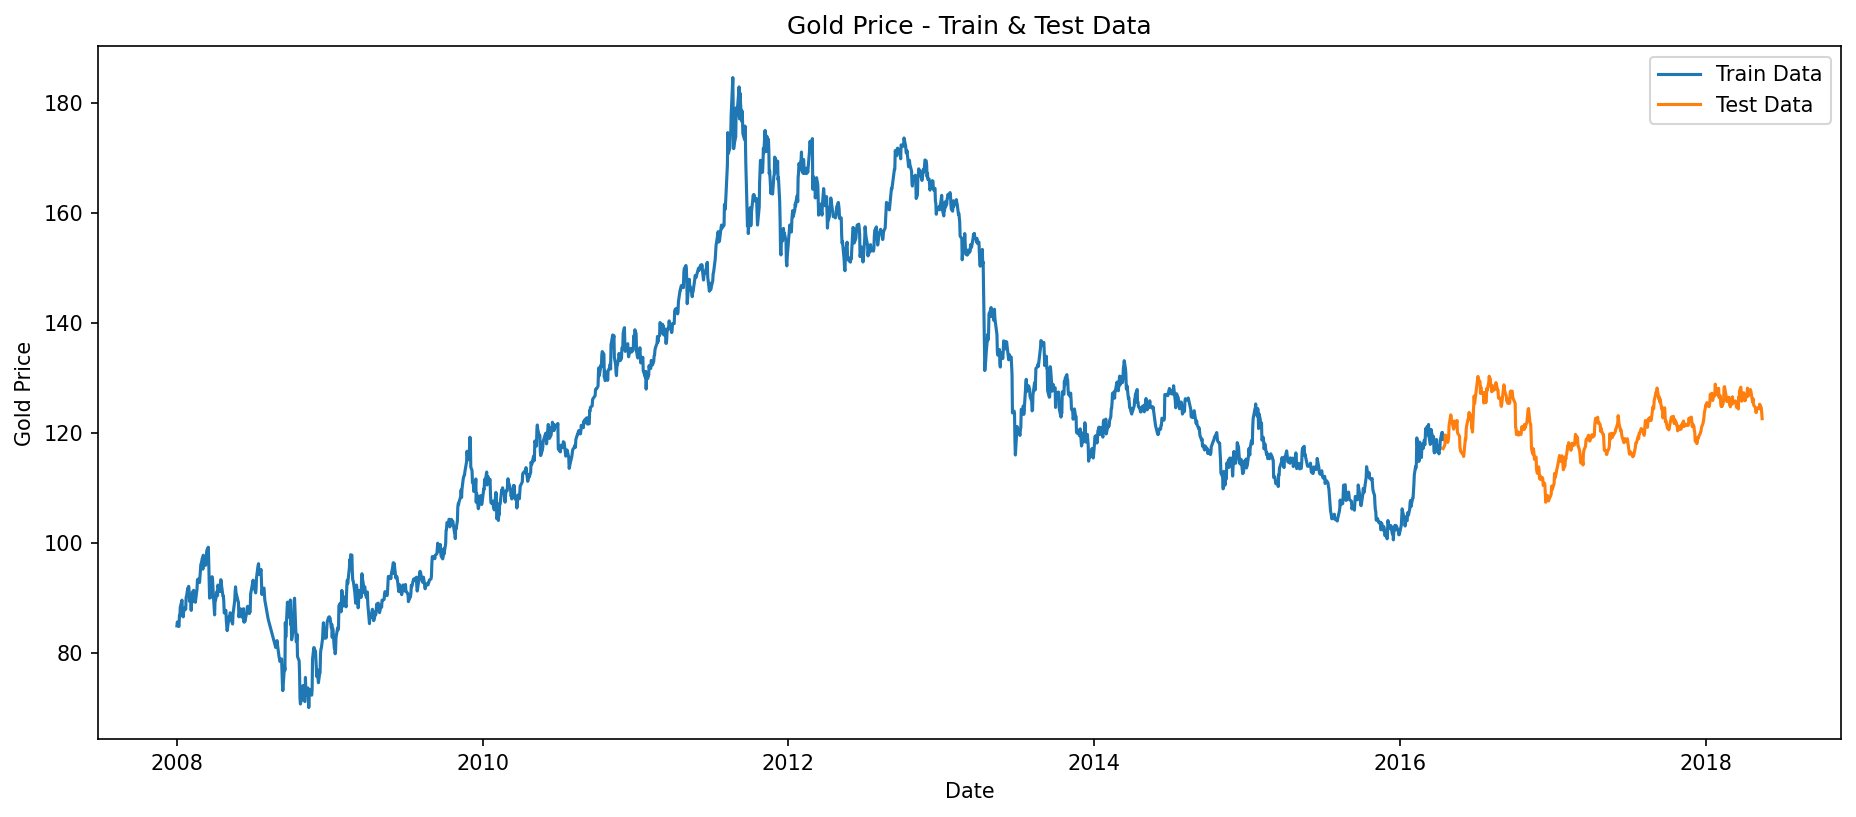

In [4]:
# Thiết lập kích thước biểu đồ với chiều rộng full (ví dụ 15 inch)
plt.figure(figsize=(15, 6), dpi=150)

# Vẽ biểu đồ cho tập huấn luyện (train)
plt.plot(train_data['GLD'], label='Train Data')

# Vẽ biểu đồ cho tập kiểm tra (test)
plt.plot(test_data['GLD'], label='Test Data')

# Thêm tiêu đề và nhãn
plt.title('Gold Price - Train & Test Data')
plt.xlabel('Date')
plt.ylabel('Gold Price')

# Chú thích
plt.legend()

# Hiển thị biểu đồ
plt.grid(color='white')
plt.show()

### 4. Thông tin chi tiết của tập Train và Test

In [5]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1832 entries, 2008-01-02 to 2016-04-13
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GLD      1832 non-null   float64
 1   USO      1832 non-null   float64
 2   SLV      1832 non-null   float64
 3   EUR/USD  1832 non-null   float64
dtypes: float64(4)
memory usage: 71.6 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 458 entries, 2016-04-14 to 2018-05-16
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GLD      458 non-null    float64
 1   USO      458 non-null    float64
 2   SLV      458 non-null    float64
 3   EUR/USD  458 non-null    float64
dtypes: float64(4)
memory usage: 17.9 KB


## 5. Khởi tạo và huấn luyện mô hình RNN

In [6]:
from keras.layers import SimpleRNN, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler


In [7]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['GLD']])

In [8]:
import numpy as np
# Số bước thời gian đầu vào
lookback = 60

# Chuẩn bị dữ liệu cho RNN
X = []
y = []

# Xây dựng các chuỗi đầu vào (input sequences) dựa trên `lookback` 
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])  # Lấy 60 bước thời gian trước đó
    y.append(scaled_data[i, 0])  # Giá trị tiếp theo làm mục tiêu

X, y = np.array(X), np.array(y)

# Reshape dữ liệu thành (samples, time_steps, features) cho RNN
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [9]:
# Tách dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(X.shape[0] * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
from keras.models import Sequential
# Xây dựng mô hình RNN
model = Sequential()

# Thêm lớp Input để xác định hình dạng đầu vào
model.add(Input(shape=(lookback, 1)))

# Thêm các lớp RNN và Dropout
model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))

# Thêm lớp đầu ra
model.add(Dense(units=1))  # Dự đoán một giá trị (giá vàng tiếp theo)

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1746 - val_loss: 0.0010
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0249 - val_loss: 0.0021
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0148 - val_loss: 4.0302e-04
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0113 - val_loss: 6.3184e-04
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0082 - val_loss: 2.3980e-04
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0071 - val_loss: 5.2902e-04
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0055 - val_loss: 3.6405e-04
Epoch 8/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0058 - val_loss: 2.1626e-04
Epoch 9/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0046 - val_loss: 1.9551e-04
Epoch 10/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0042 - val_loss: 5.2916e-04
Epoch 11/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0042 - val_loss: 1.7033e-04
Epoch 12/150
56/

### 6. Dự đoán và tính toán các độ đo

In [12]:
# Dự đoán trên tập kiểm tra
predicted_prices = model.predict(X_test)
#predicted_prices = scaler.inverse_transform(predicted_prices)

# Giải mã giá trị thực tế
#real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [13]:
# Đảo ngược chuẩn hóa cho y_test
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Đảo ngược chuẩn hóa cho predicted_prices
predictions_rescaled = scaler.inverse_transform(predicted_prices).flatten()

In [14]:
# Tính toán các chỉ số đánh giá

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled) * 100 

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))

# R-squared (R²)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 0.8391406136359656
MAPE: 0.6894071173958892%
RMSE: 1.110662146460168
R²: 0.9484017720854284


### 7. Biểu đồ dự đoán của mô hình

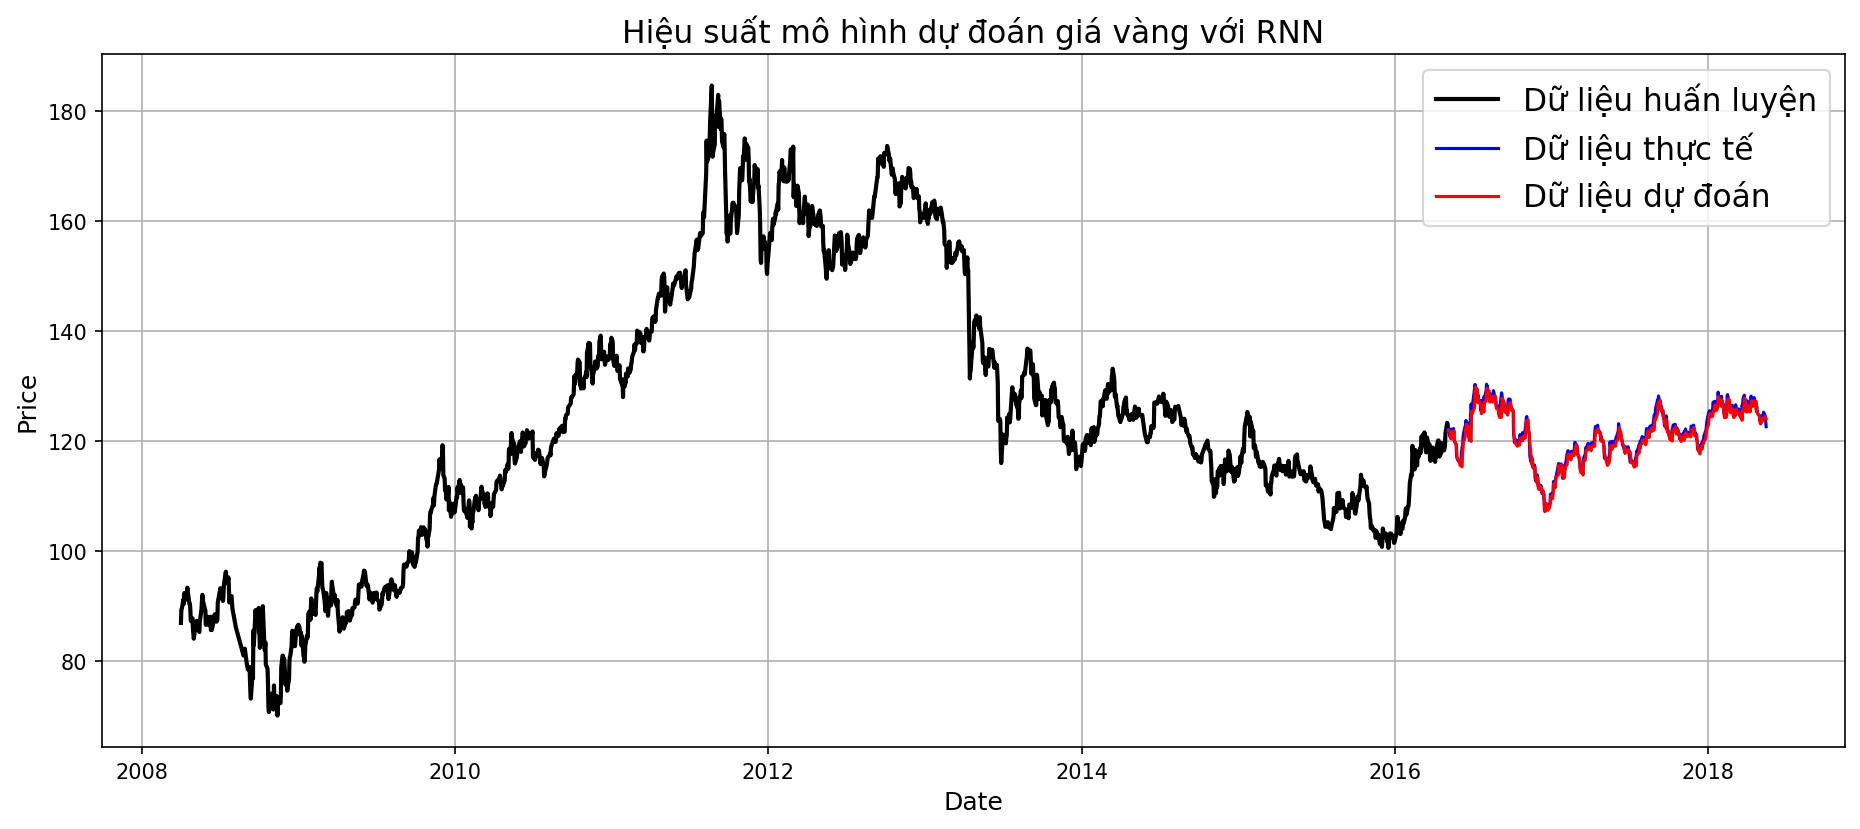

In [15]:
plt.figure(figsize=(15, 6), dpi=150)

sequence_length = 60

# Đảo ngược chuẩn hóa cho y_train
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Sau đó vẽ lại dữ liệu huấn luyện
plt.plot(df.index[lookback:train_size + lookback], y_train_rescaled, color='black', lw=2, label='Dữ liệu huấn luyện')

# Vẽ dữ liệu thực tế từ tập kiểm tra
plt.plot(df.index[train_size + lookback:], y_test_rescaled, label='Dữ liệu thực tế', color='blue')

# Vẽ dữ liệu dự đoán
plt.plot(df.index[train_size + lookback:], predictions_rescaled, label='Dữ liệu dự đoán', color='red')

# Thêm tiêu đề, nhãn, và chú thích
plt.title('Hiệu suất mô hình dự đoán giá vàng với RNN', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)
plt.legend(['Dữ liệu huấn luyện', 'Dữ liệu thực tế', 'Dữ liệu dự đoán'], prop={'size': 15})

# Hiển thị biểu đồ
plt.show()
